In [20]:
'''
Description: 

Normal autoencoders have the issue that the latent space is irregular. 
VAE modifications: 
- Encoder outputs a distribution in the latent space for some input
- Then sample a point from this distribution for decoding 
- Calculate the reconstruction error from the decoded sample (like usual)
- Since sampling from the encoded latent distribution is a discrete operation, it's not differentiable 
    - to make backpropogation work, need to use a reparameterisation trick 
        - this lets us perform a differentiable sampling operation 
- VAE loss two parts: 
    1. Reconstruction loss 
    2. Regularization term - KL divergence between encoded latent distribution and normal distribution 
        (try to keep the encoded distribution close to normal)

'''

import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd 
import random 
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

data_dir = 'dataset'

train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

train_transform = transforms.Compose([
transforms.ToTensor(),
])

test_transform = transforms.Compose([
transforms.ToTensor(),
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

m=len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
batch_size=256

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)


In [21]:
# VariationEncoder returns mean/variance matrices, which are used to sample the latent vector
#   Also get the KL Divergence term here 

class VariationalEncoder(nn.Module): 

    def __init__(self, latent_dims): 
        super(VariationalEncoder, self).__init__() 

        self.conv1 = nn.Conv2d(1, 8, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
        self.batch2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=2, padding=0)
        self.linear1 = nn.Linear(3*3*32, 128)
        self.linear2 = nn.Linear(128, latent_dims) # This outputs the mean tensor 
        self.linear3 = nn.Linear(128, latent_dims) # This outputs the std tensor 

        self.N = torch.distributions.Normal(0, 1)

        # DEV: not sure about this 
        self.N.loc = self.N.loc.to(device)
        self.N.scale = self.N.scale.to(device)
        self.kl = 0

    def forward(self, x): 
        x = x.to(device)
        x = F.relu(self.conv1(x))
        x = F.relu(self.batch2(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu = self.linear2(x)
        sigma = torch.exp(self.linear3(x))

        # Sample from the guassian distribution outputted by the encoder 
        z = mu + sigma*self.N.sample(mu.shape)

        # KL Divergence measures how different this distribution is from standard normal N(0, 1)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z
    
class Decoder(nn.Module): 

    def __init__(self, latent_dims): 
        super().__init__()

        self.decoder_lin = nn.Sequential(
            nn.Linear(latent_dims, 128),
            nn.ReLU(True), 
            nn.Linear(128, 3*3*32), 
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8), 
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )

    def forward(self, x): 
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x
    
class VariationalAutoencoder(nn.Module): 

    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)
    
    def forward(self, x): 
        x = x.to(device)
        z = self.encoder(x)
        return self.decoder(z)
    

In [22]:
torch.manual_seed(0)
d = 4
vae = VariationalAutoencoder(latent_dims=d)
lr = 1e-3
optim = torch.optim.Adam(vae.parameters(), lr=lr, weight_decay=1e-5)
vae.to(device)

VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (batch2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (linear1): Linear(in_features=288, out_features=128, bias=True)
    (linear2): Linear(in_features=128, out_features=4, bias=True)
    (linear3): Linear(in_features=128, out_features=4, bias=True)
  )
  (decoder): Decoder(
    (decoder_lin): Sequential(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=128, out_features=288, bias=True)
      (3): ReLU(inplace=True)
    )
    (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
    (decoder_conv): Sequential(
      (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchN

In [23]:
def train_epoch(vae, device, dataloader, optimizer): 

    vae.train()
    train_loss = 0.0

    for x, _ in dataloader:

        x = x.to(device)
        x_hat = vae(x)

        # TODO: Do we want to weight the loss? 
        loss = ((x - x_hat)**2).sum() + vae.encoder.kl

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    return train_loss / len(dataloader.dataset)

def test_epoch(vae, device, dataloader): 
    vae.eval()
    val_loss = 0.0

    with torch.no_grad(): 
        for x, _ in dataloader: 
            x = x.to(device)
            x_hat = vae(x)
            loss = ((x - x_hat)**2).sum() + vae.encoder.kl
            val_loss += loss.item()
    
    return val_loss / len(dataloader.dataset)



In [24]:

def plot_ae_outputs(encoder,decoder,n=10):
    plt.figure(figsize=(16,4.5))
    targets = test_dataset.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_dataset[t_idx[i]][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show() 


 EPOCH 1/50 	 train loss 142.131 	 val loss 77.420


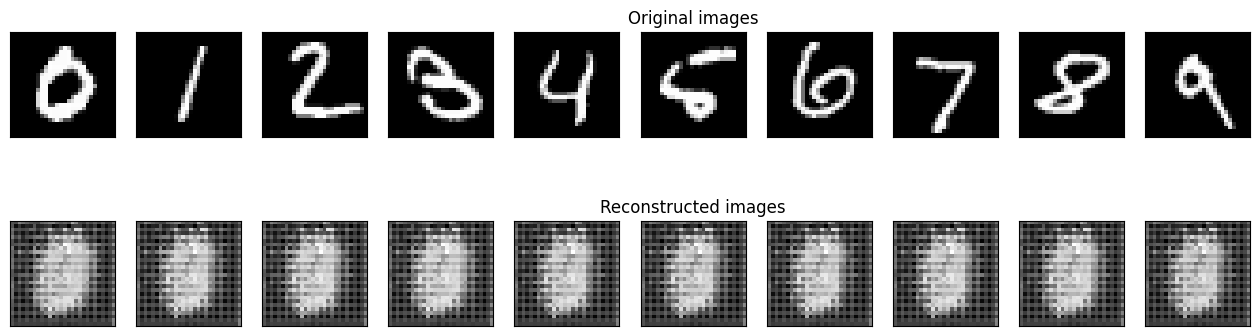


 EPOCH 2/50 	 train loss 62.191 	 val loss 52.278


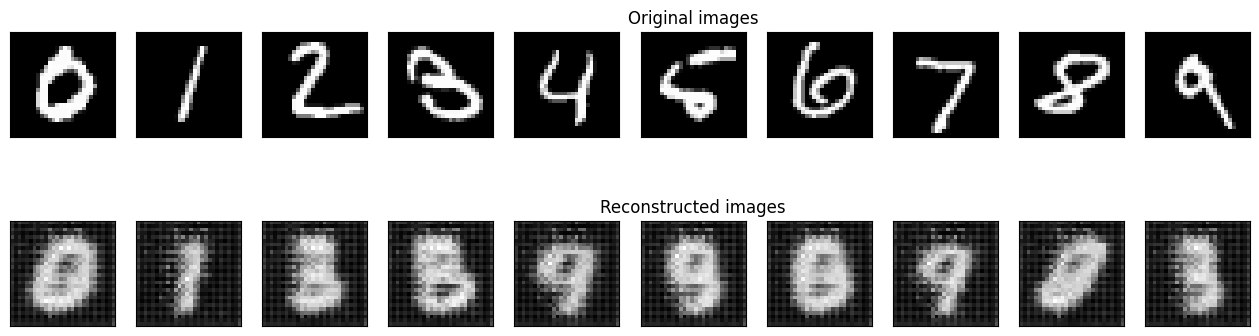


 EPOCH 3/50 	 train loss 47.462 	 val loss 43.065


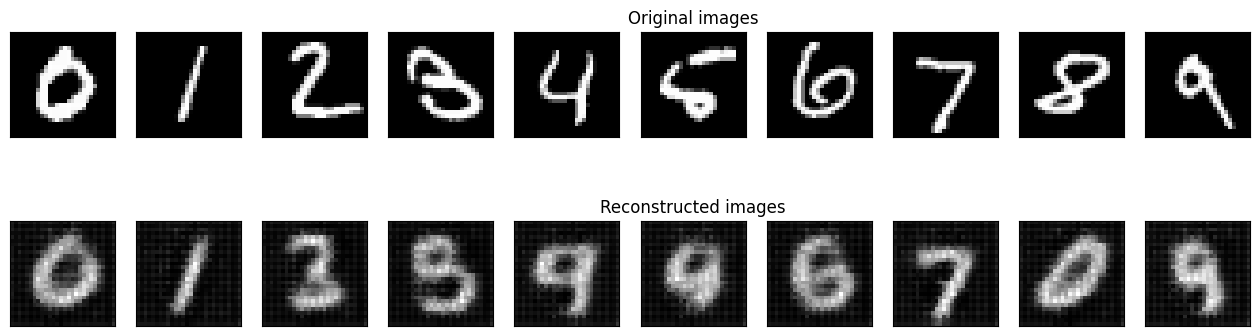


 EPOCH 4/50 	 train loss 40.553 	 val loss 38.970


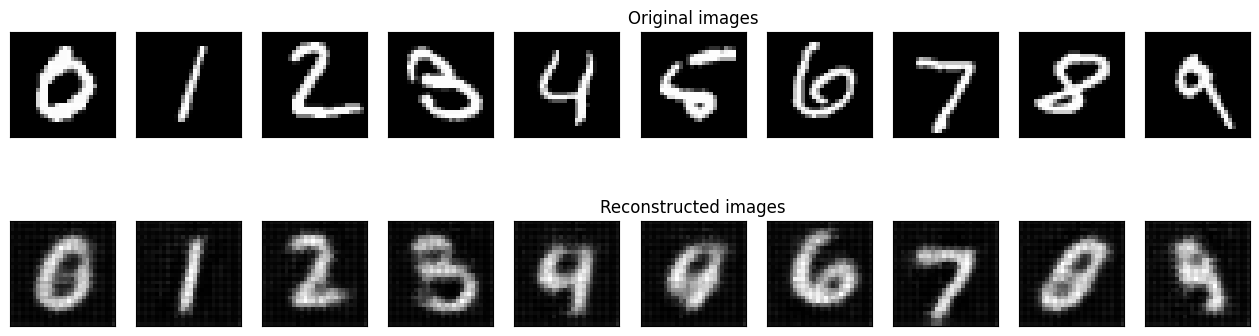


 EPOCH 5/50 	 train loss 37.775 	 val loss 37.011


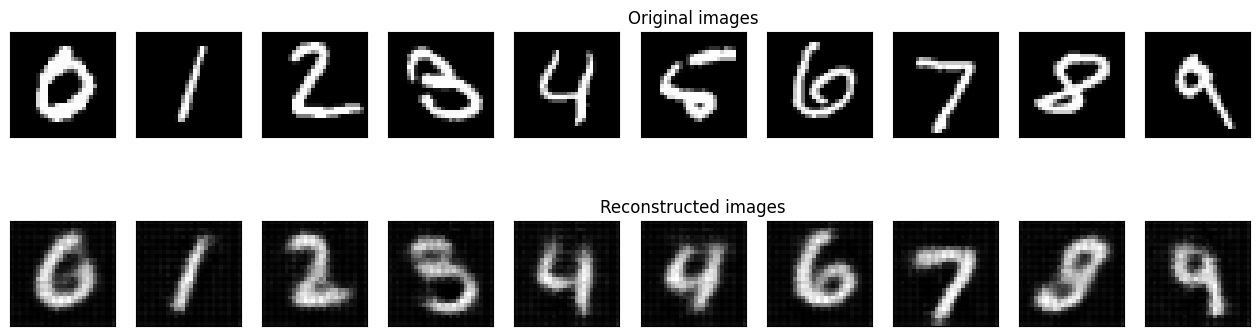


 EPOCH 6/50 	 train loss 36.487 	 val loss 36.149


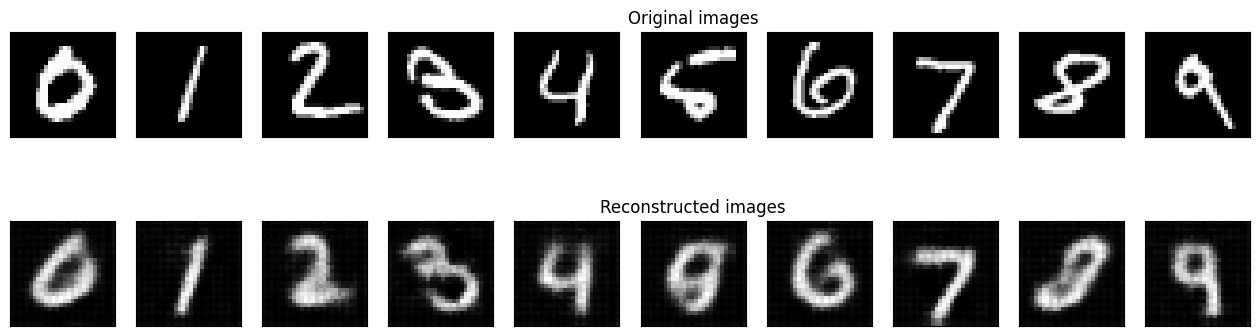


 EPOCH 7/50 	 train loss 35.696 	 val loss 35.460


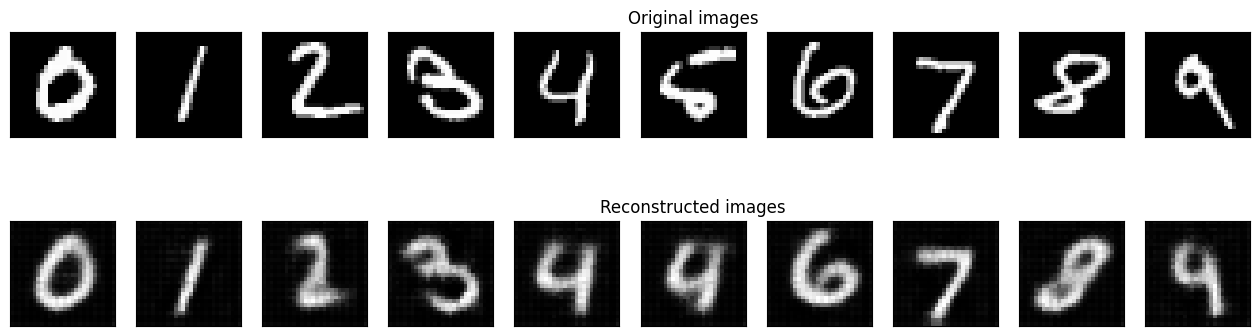


 EPOCH 8/50 	 train loss 35.124 	 val loss 35.176


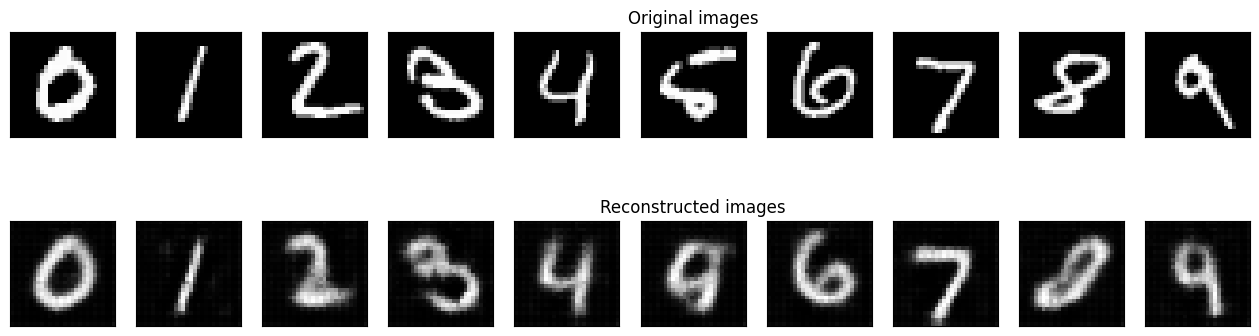


 EPOCH 9/50 	 train loss 34.739 	 val loss 34.664


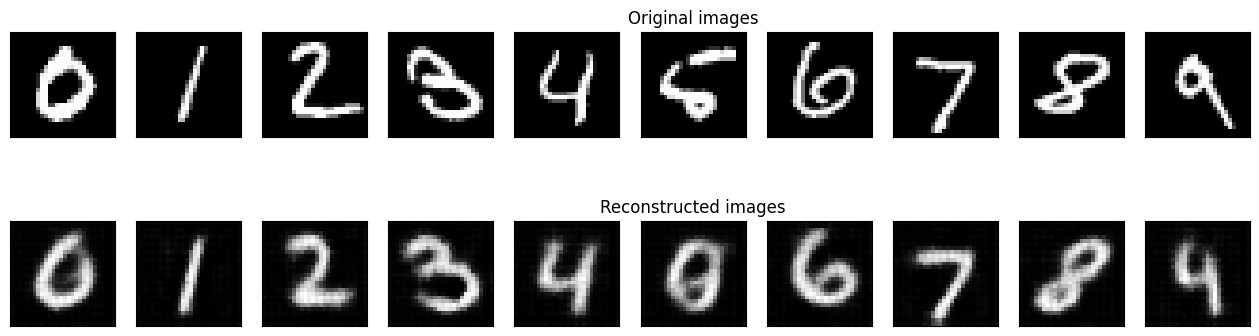


 EPOCH 10/50 	 train loss 34.417 	 val loss 34.506


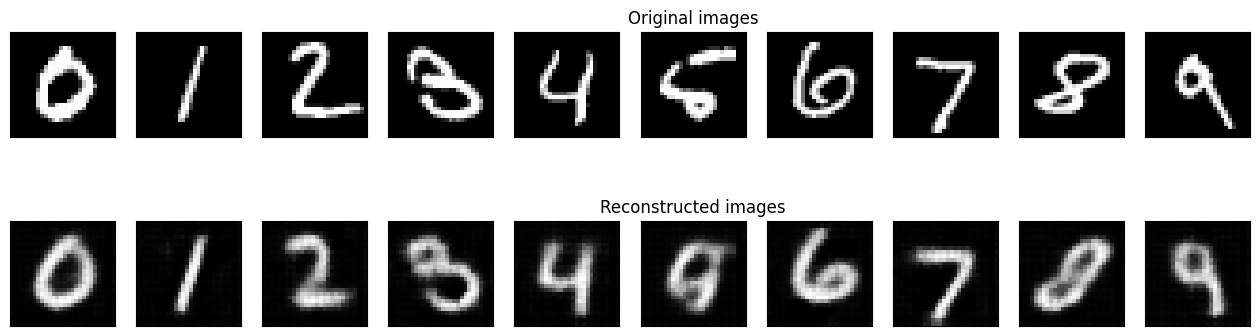


 EPOCH 11/50 	 train loss 34.214 	 val loss 34.268


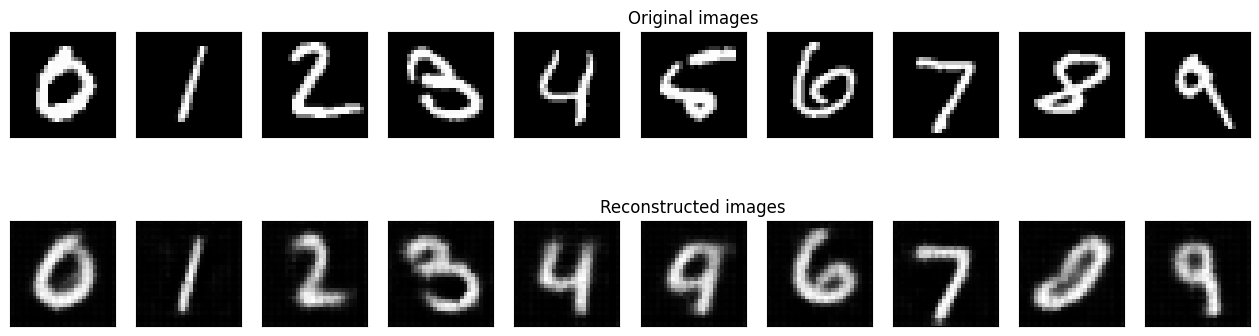


 EPOCH 12/50 	 train loss 33.965 	 val loss 34.086


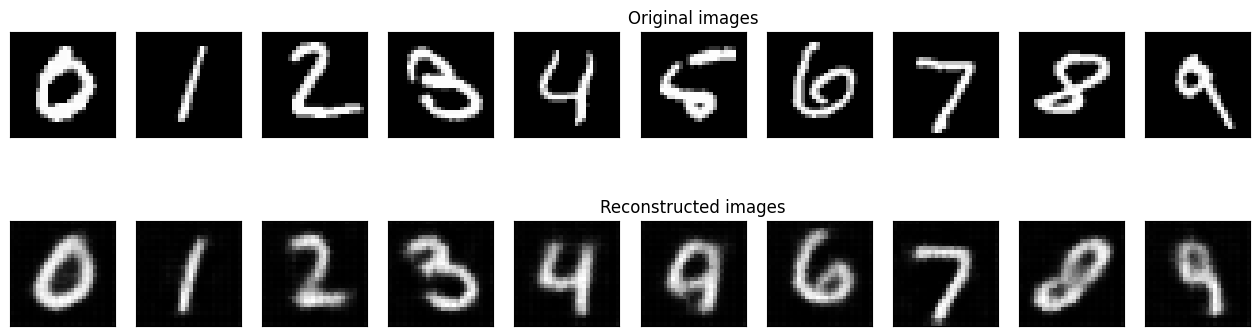


 EPOCH 13/50 	 train loss 33.832 	 val loss 33.909


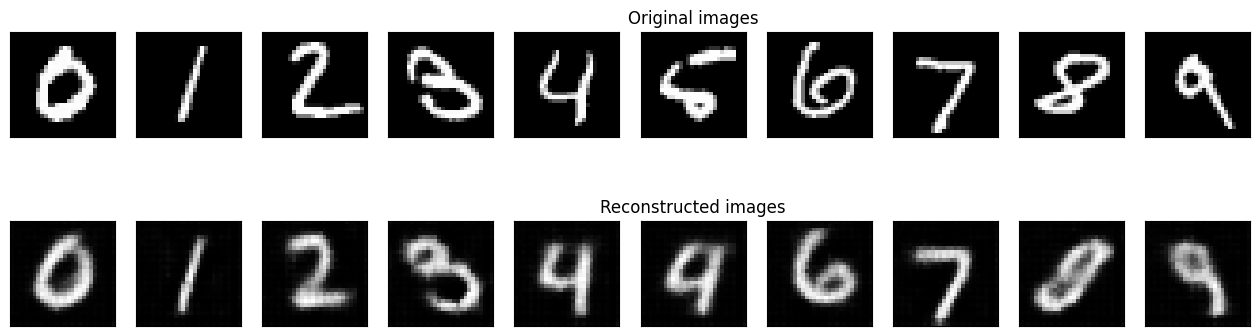


 EPOCH 14/50 	 train loss 33.654 	 val loss 33.728


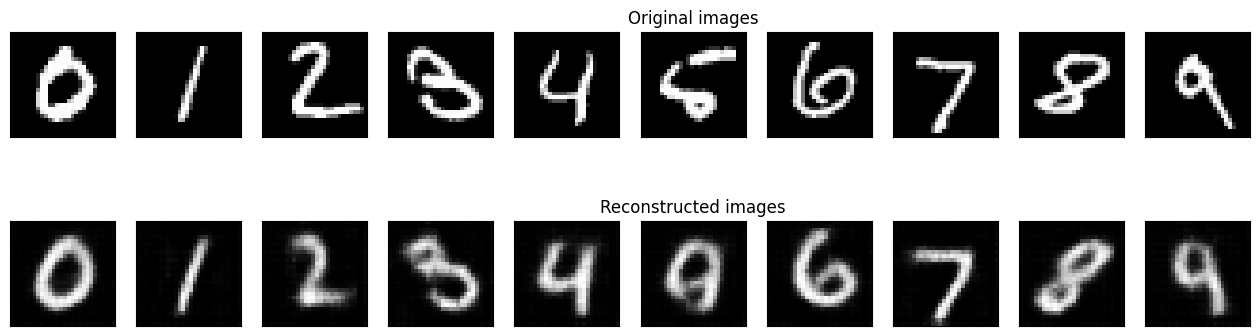


 EPOCH 15/50 	 train loss 33.541 	 val loss 33.768


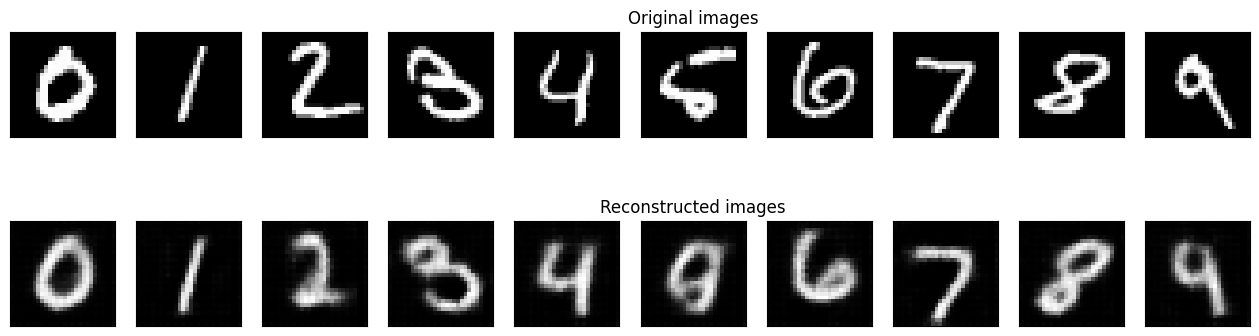


 EPOCH 16/50 	 train loss 33.403 	 val loss 33.589


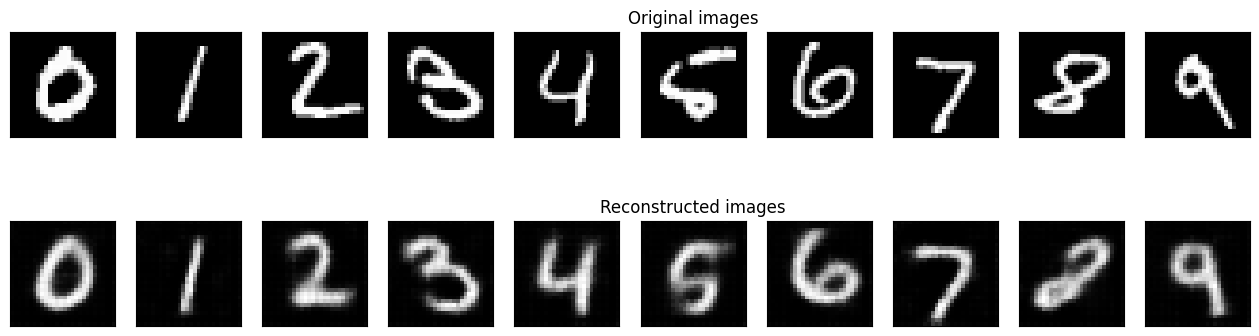


 EPOCH 17/50 	 train loss 33.276 	 val loss 33.464


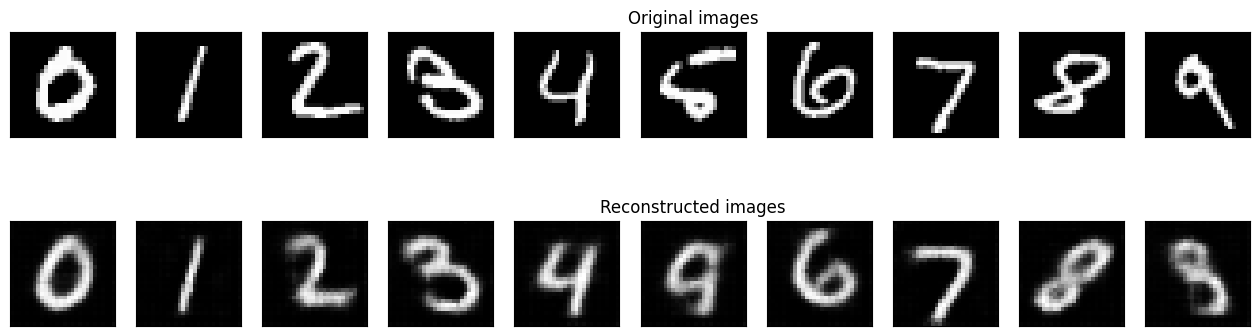


 EPOCH 18/50 	 train loss 33.193 	 val loss 33.362


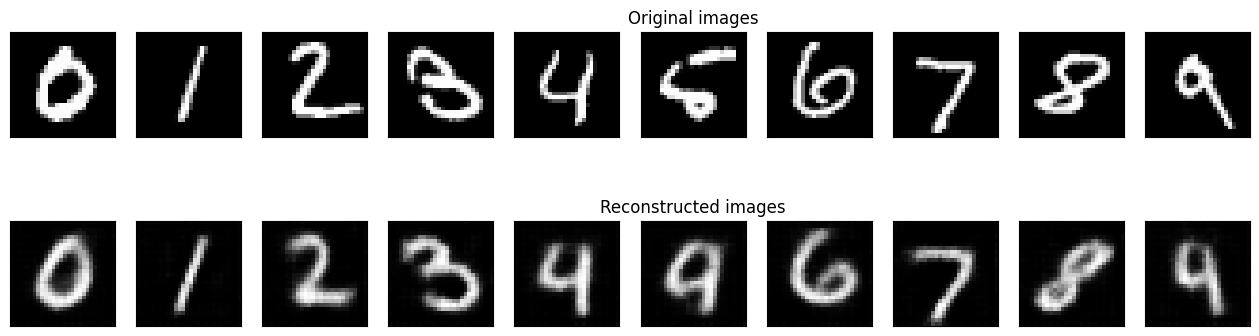


 EPOCH 19/50 	 train loss 33.113 	 val loss 33.332


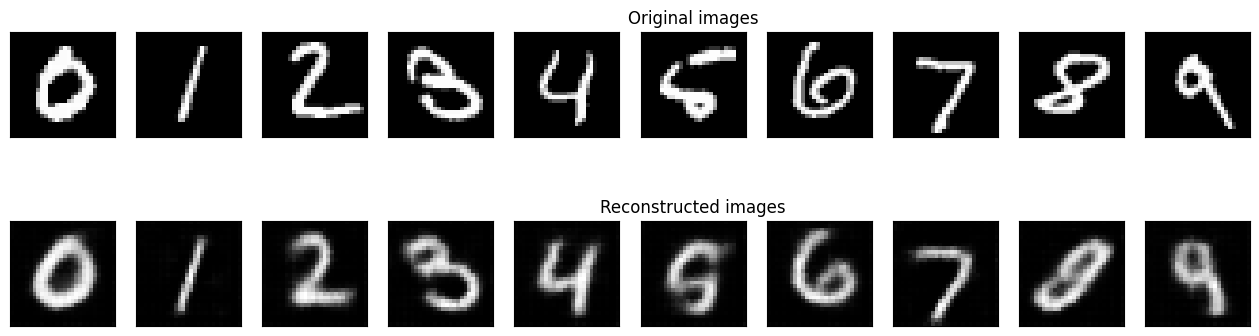


 EPOCH 20/50 	 train loss 33.018 	 val loss 33.246


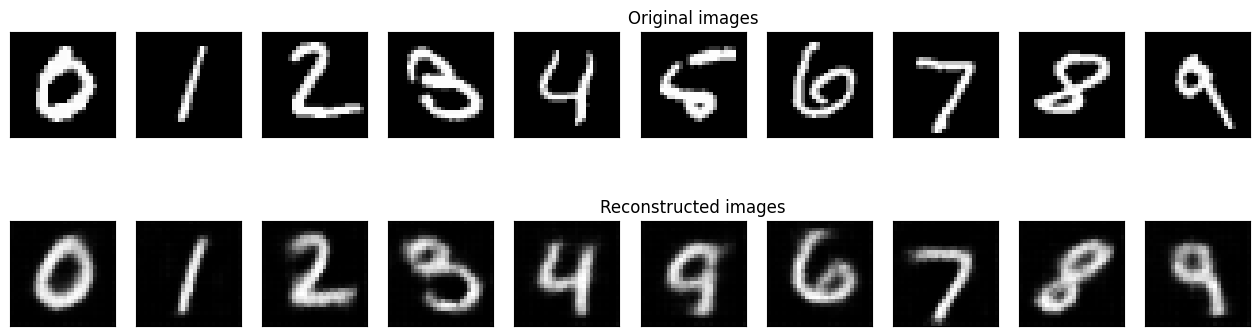


 EPOCH 21/50 	 train loss 32.939 	 val loss 33.199


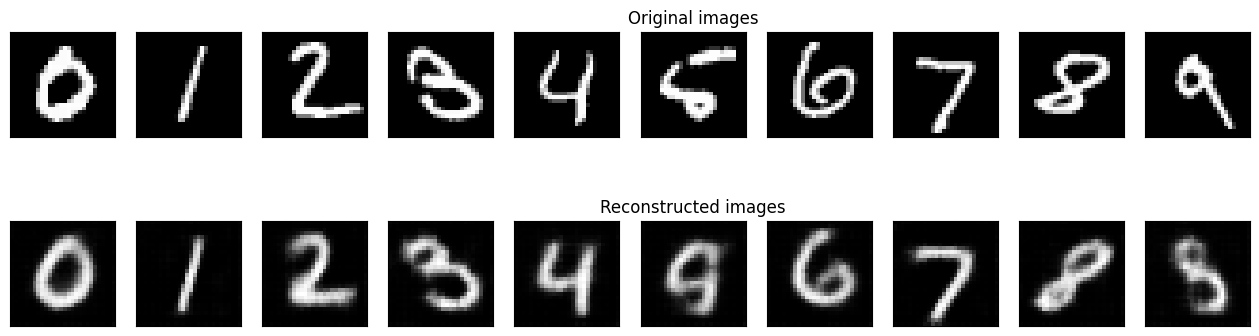


 EPOCH 22/50 	 train loss 32.868 	 val loss 33.022


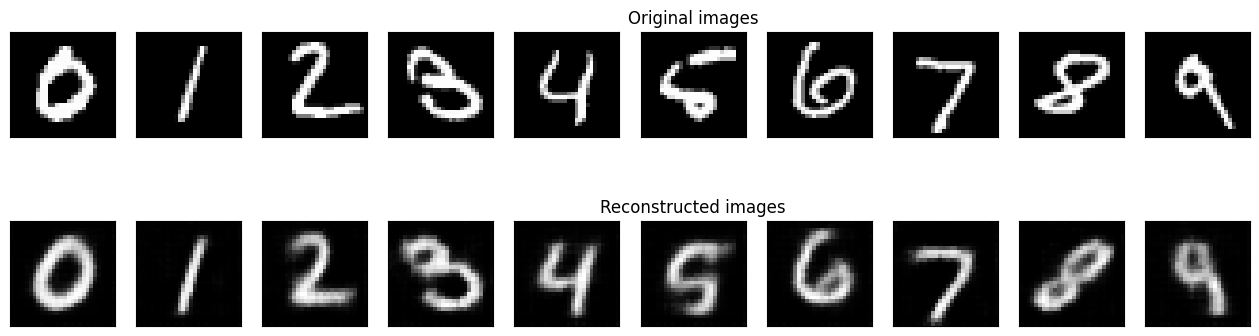


 EPOCH 23/50 	 train loss 32.797 	 val loss 33.025


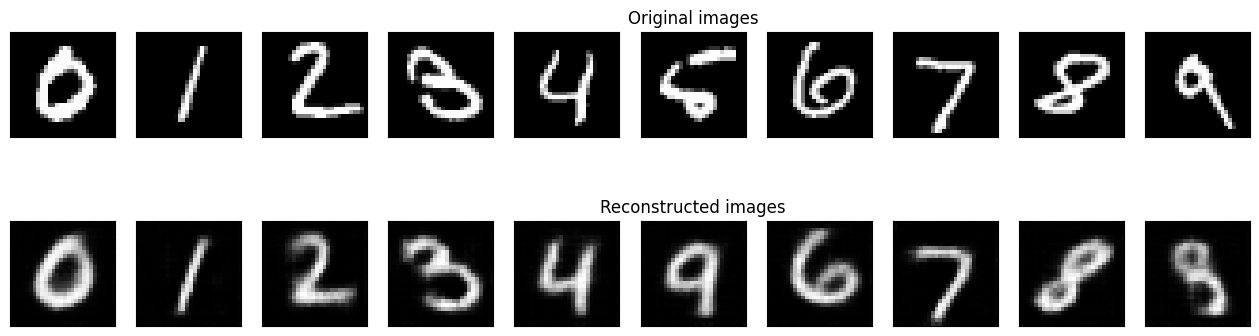


 EPOCH 24/50 	 train loss 32.734 	 val loss 32.954


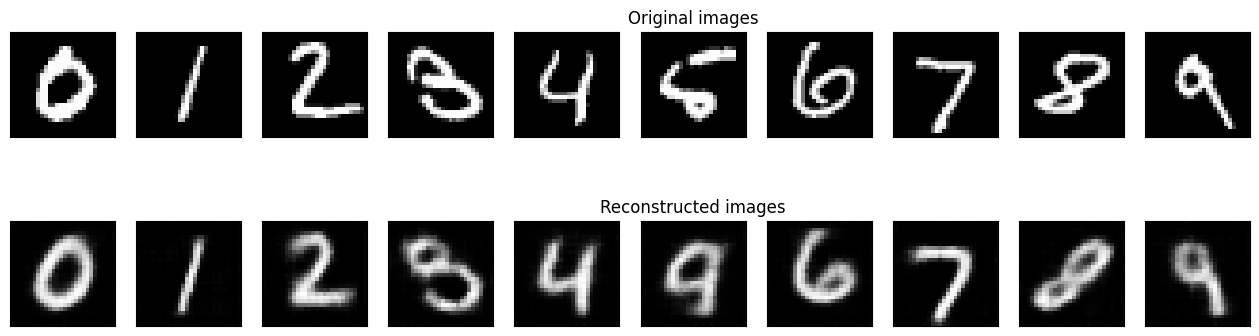


 EPOCH 25/50 	 train loss 32.700 	 val loss 32.860


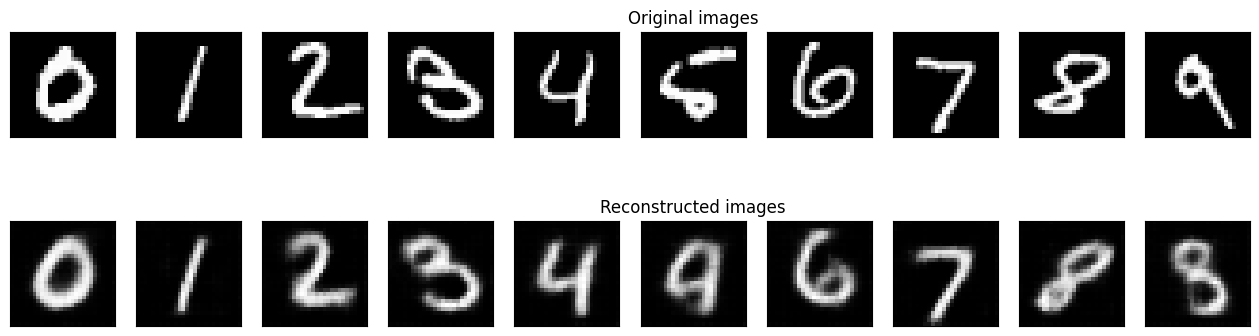


 EPOCH 26/50 	 train loss 32.651 	 val loss 32.869


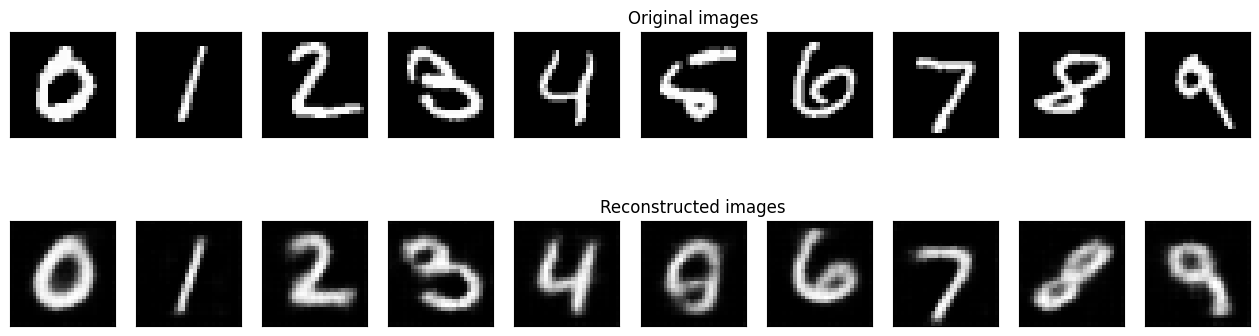


 EPOCH 27/50 	 train loss 32.574 	 val loss 32.873


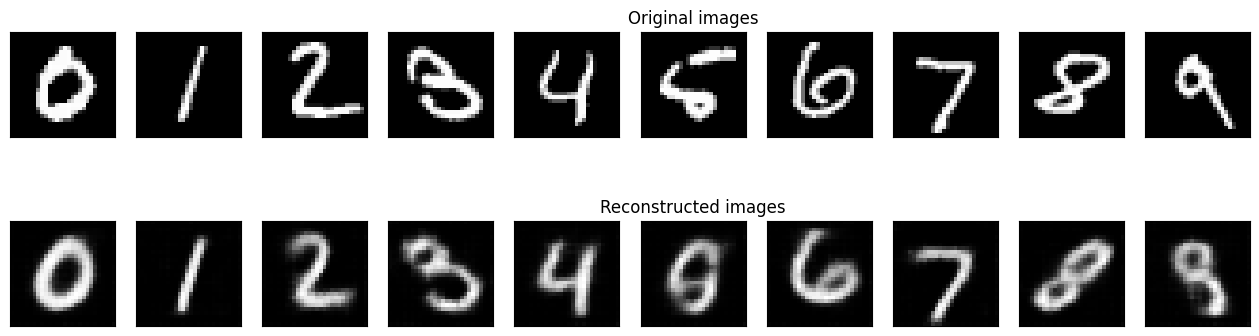


 EPOCH 28/50 	 train loss 32.541 	 val loss 32.888


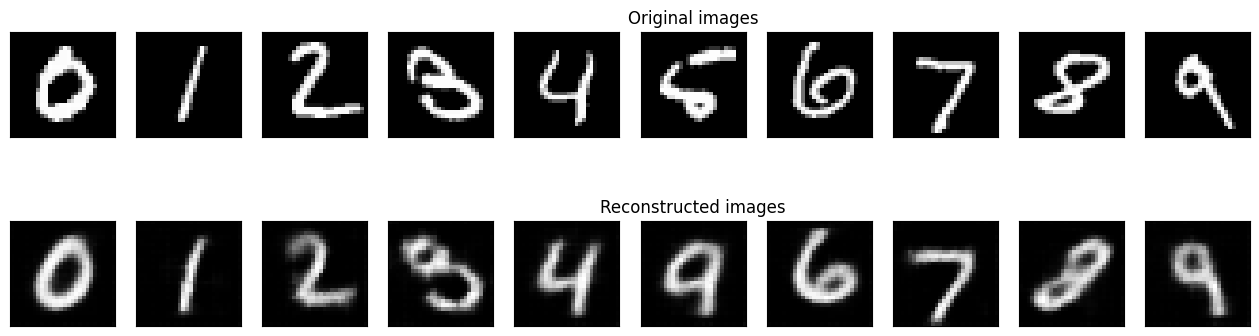


 EPOCH 29/50 	 train loss 32.495 	 val loss 32.767


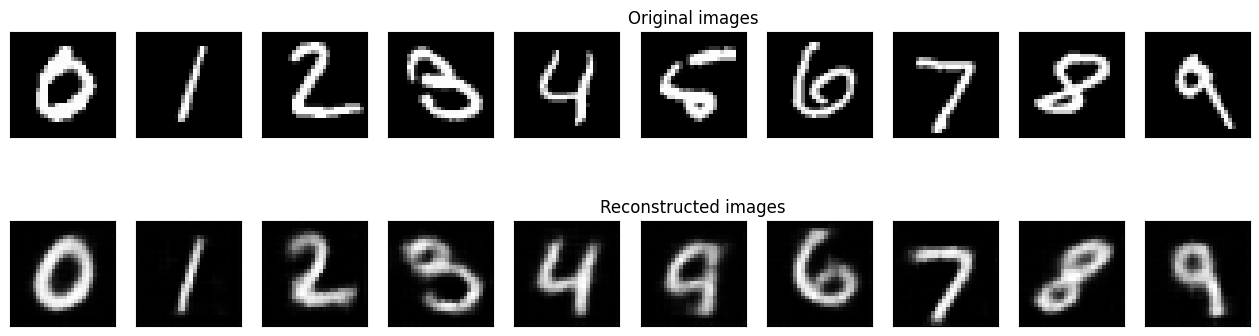


 EPOCH 30/50 	 train loss 32.434 	 val loss 32.728


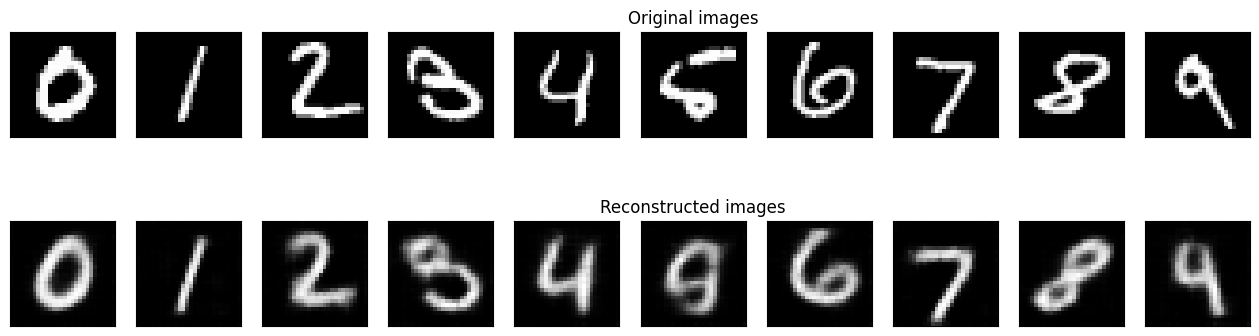


 EPOCH 31/50 	 train loss 32.410 	 val loss 32.698


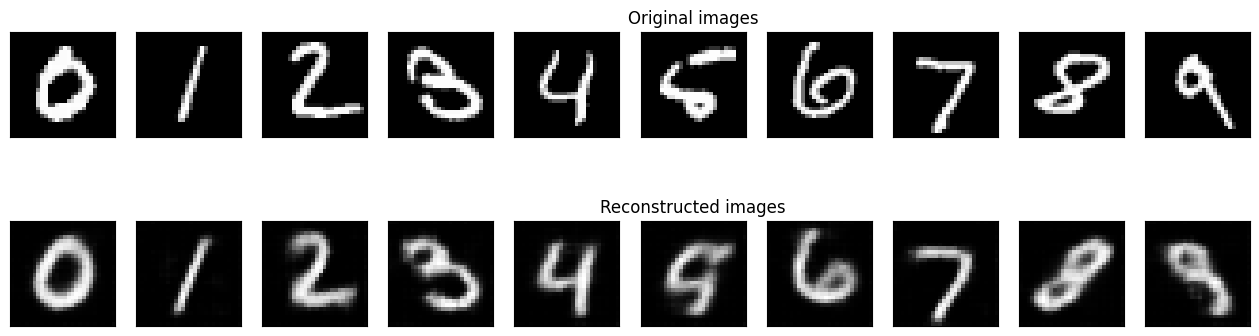


 EPOCH 32/50 	 train loss 32.370 	 val loss 32.606


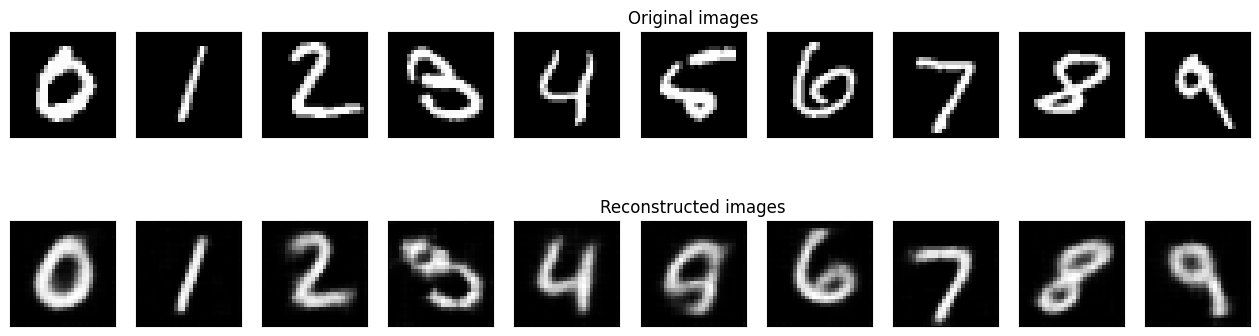


 EPOCH 33/50 	 train loss 32.325 	 val loss 32.587


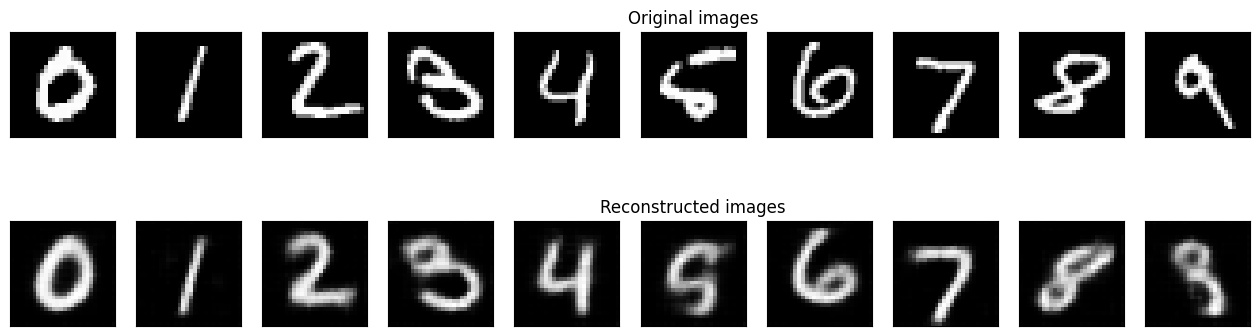


 EPOCH 34/50 	 train loss 32.299 	 val loss 32.666


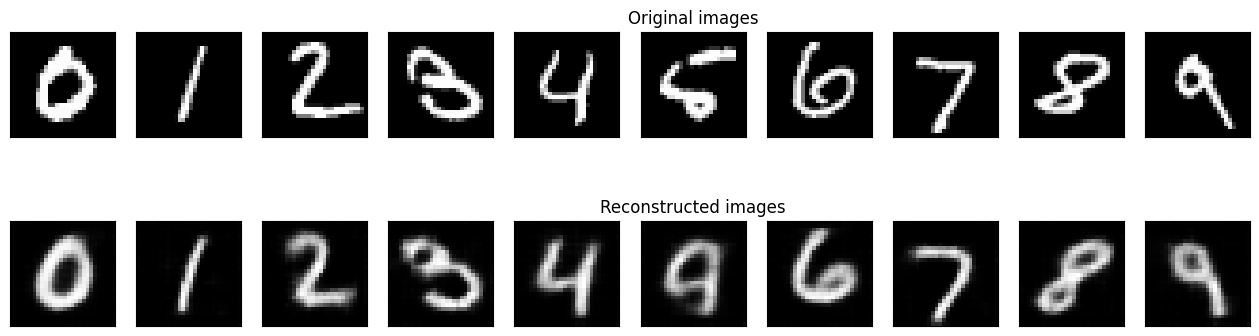


 EPOCH 35/50 	 train loss 32.257 	 val loss 32.572


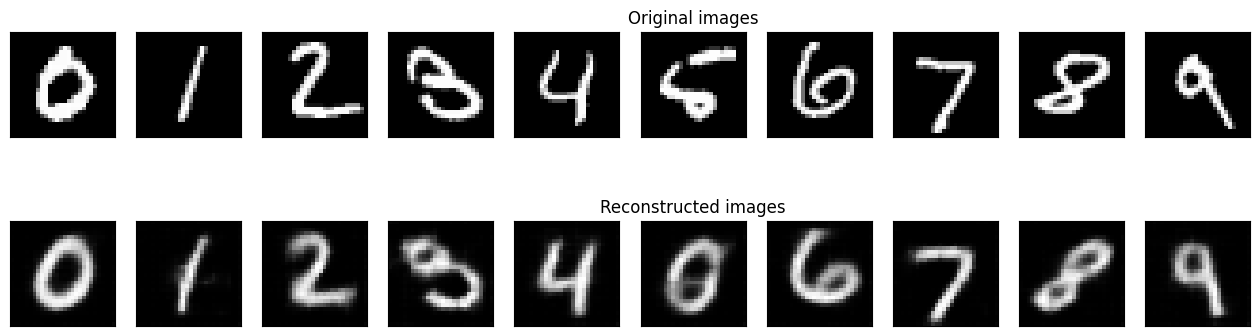


 EPOCH 36/50 	 train loss 32.202 	 val loss 32.551


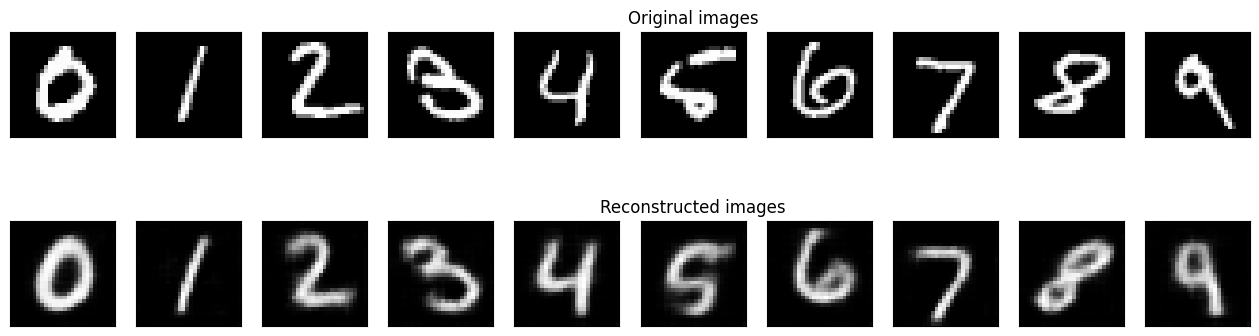


 EPOCH 37/50 	 train loss 32.193 	 val loss 32.456


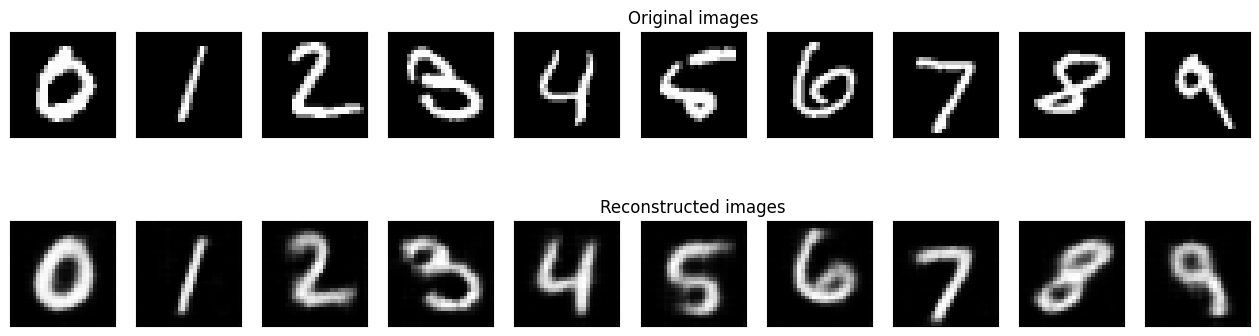


 EPOCH 38/50 	 train loss 32.162 	 val loss 32.468


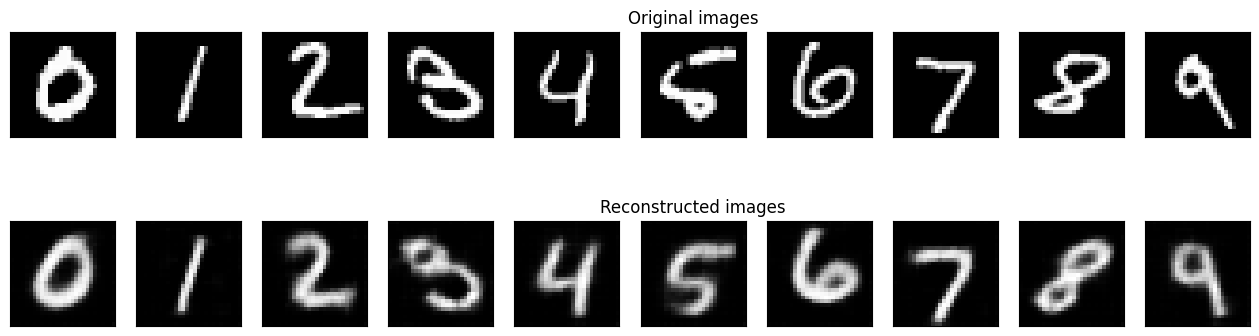


 EPOCH 39/50 	 train loss 32.158 	 val loss 32.386


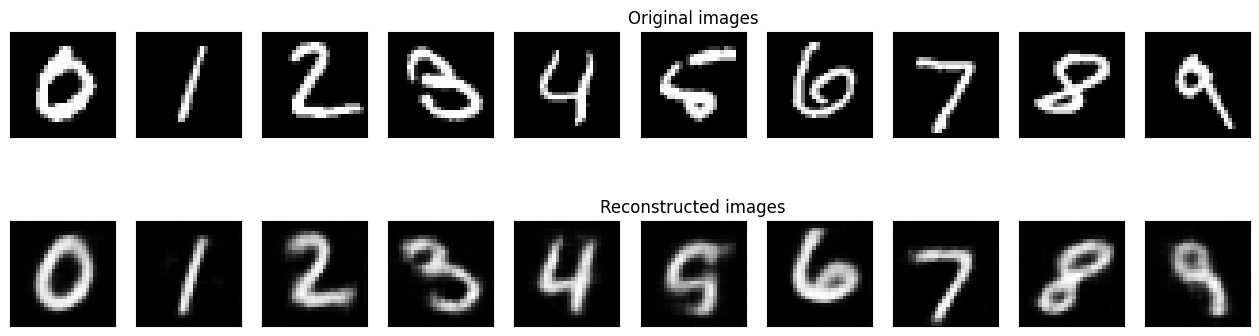


 EPOCH 40/50 	 train loss 32.090 	 val loss 32.386


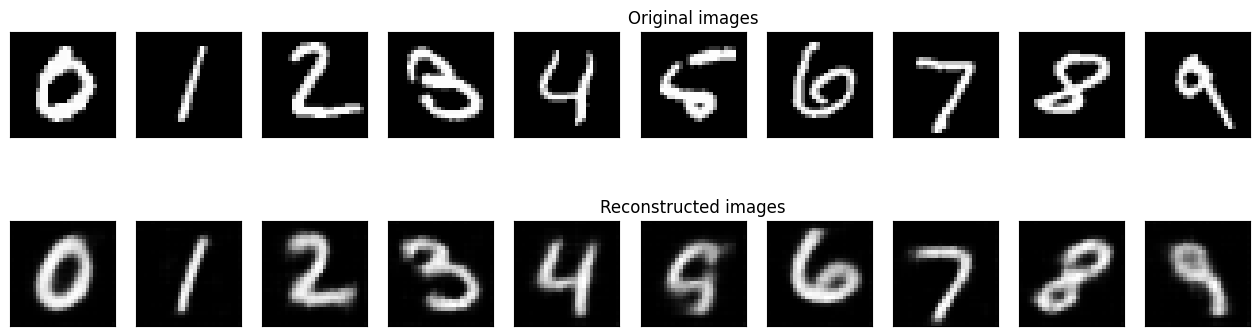


 EPOCH 41/50 	 train loss 32.096 	 val loss 32.395


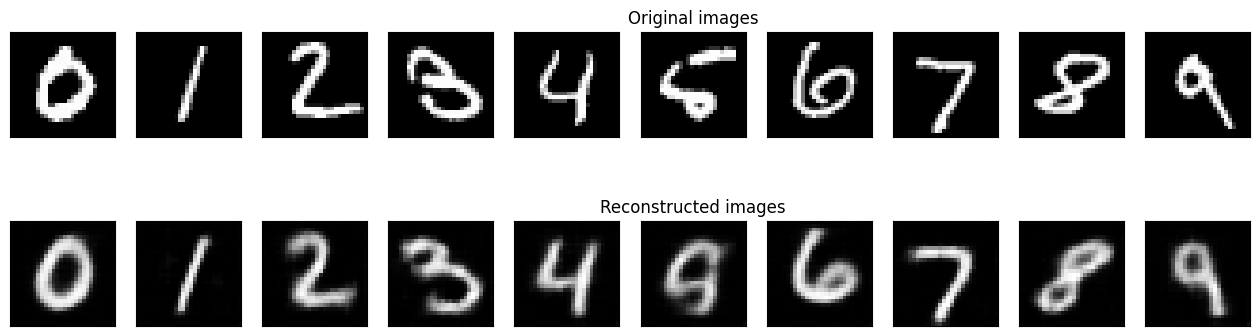


 EPOCH 42/50 	 train loss 32.073 	 val loss 32.281


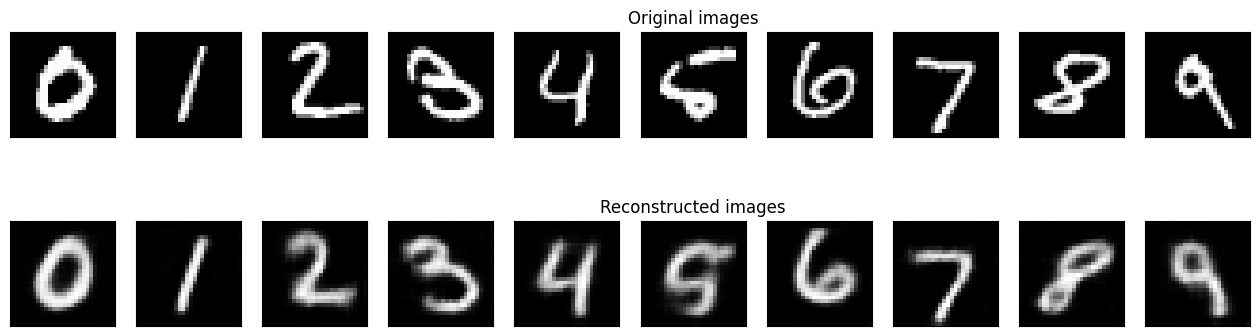


 EPOCH 43/50 	 train loss 32.037 	 val loss 32.323


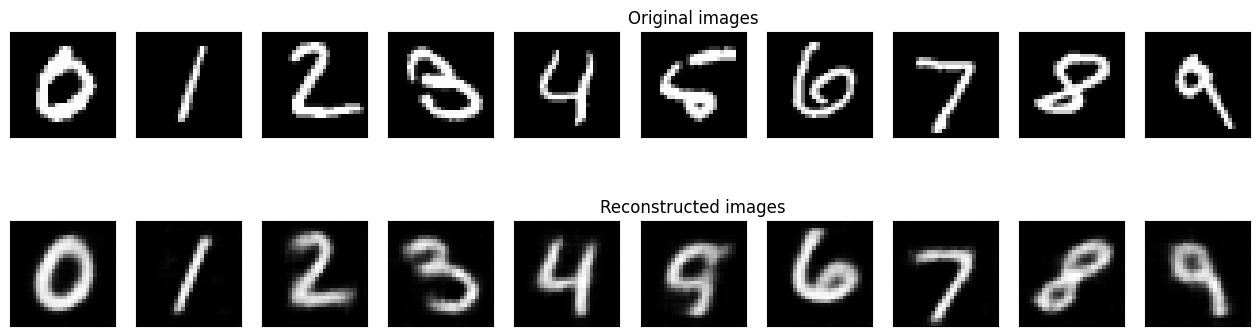


 EPOCH 44/50 	 train loss 32.020 	 val loss 32.269


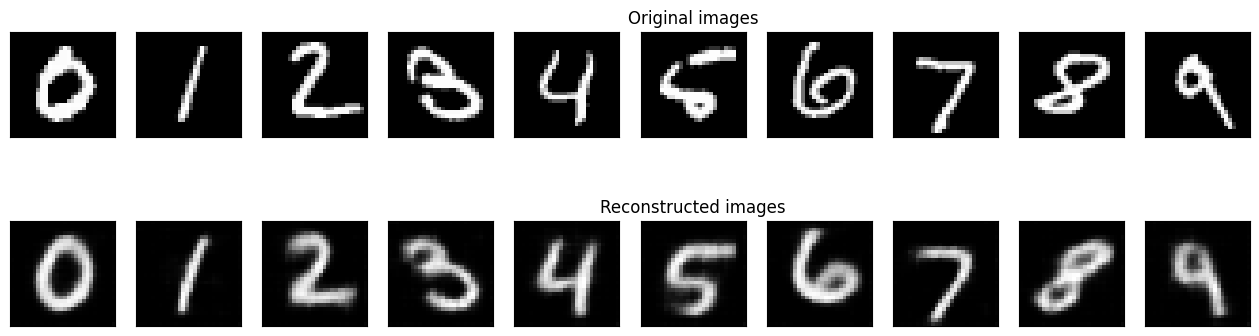


 EPOCH 45/50 	 train loss 31.998 	 val loss 32.354


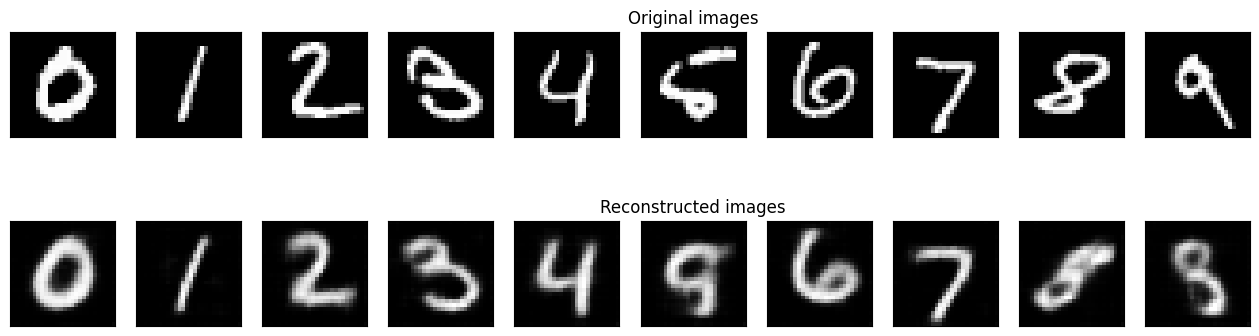


 EPOCH 46/50 	 train loss 31.929 	 val loss 32.182


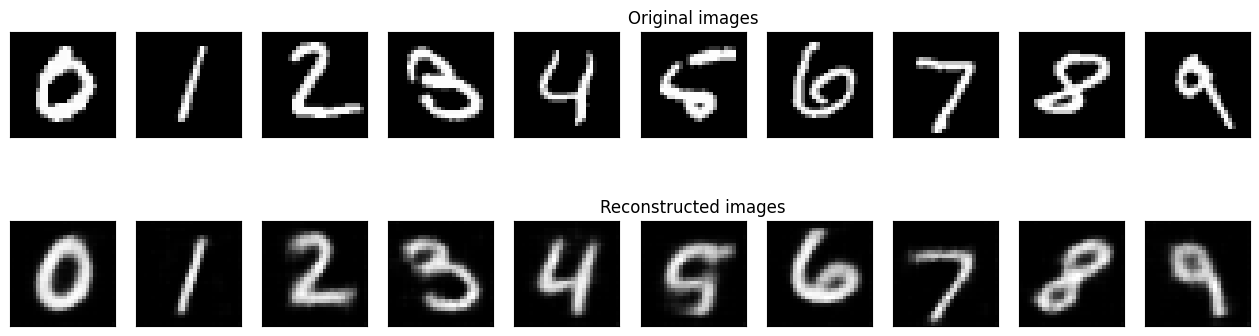


 EPOCH 47/50 	 train loss 31.928 	 val loss 32.261


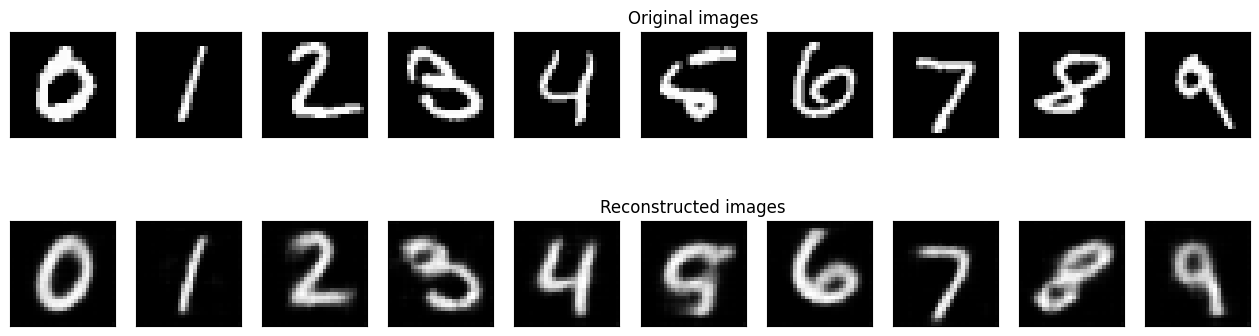


 EPOCH 48/50 	 train loss 31.909 	 val loss 32.260


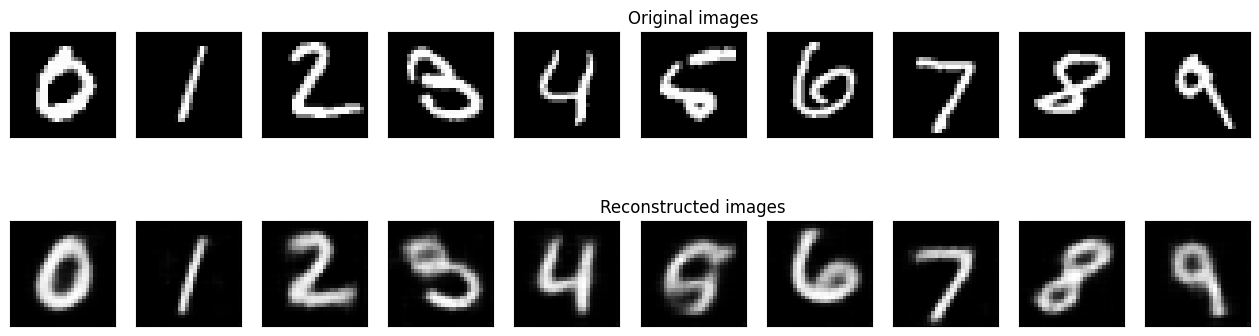


 EPOCH 49/50 	 train loss 31.882 	 val loss 32.270


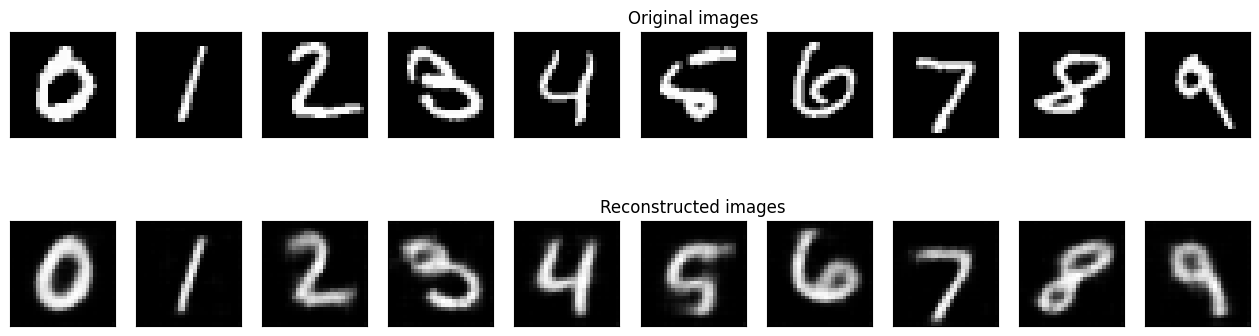


 EPOCH 50/50 	 train loss 31.874 	 val loss 32.191


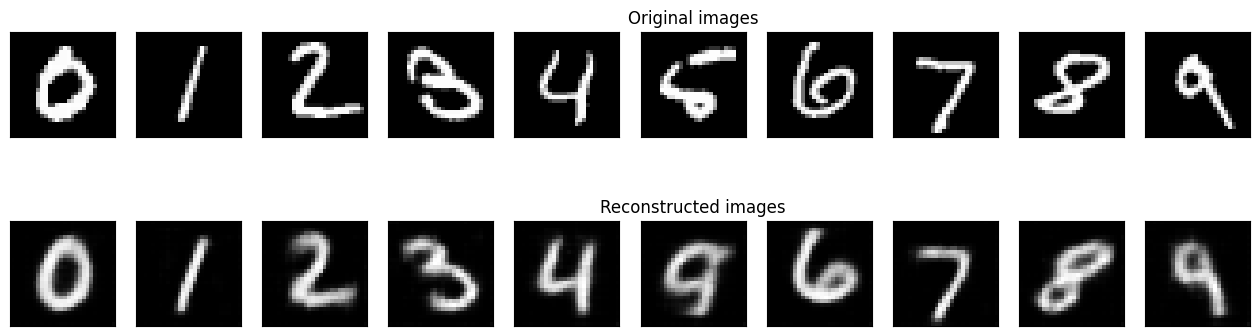

In [25]:
num_epochs = 50

for epoch in range(num_epochs): 
    train_loss = train_epoch(vae, device, train_loader, optim)
    val_loss = test_epoch(vae, device, valid_loader)
    print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
    plot_ae_outputs(vae.encoder,vae.decoder,n=10)

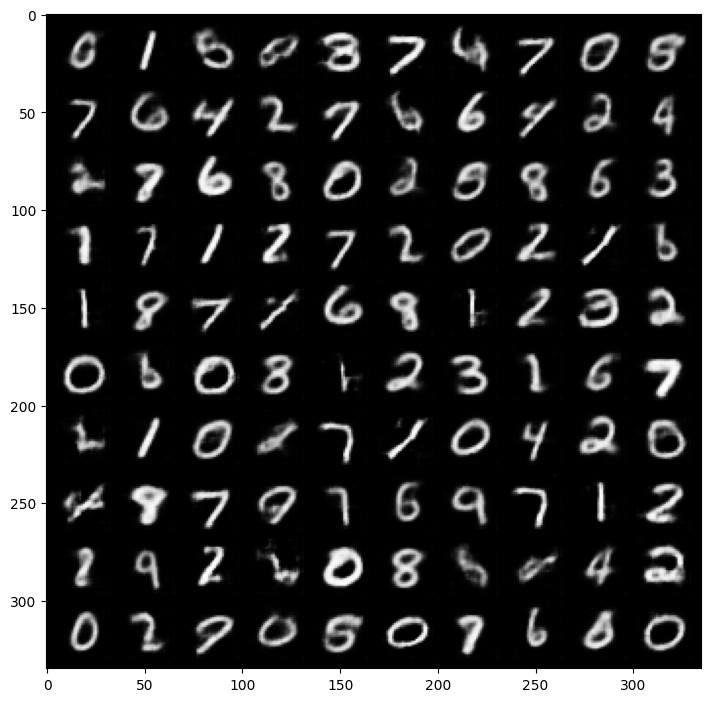

In [28]:
# Because the latent space follows a distribution (sort-of), we can sample from the prior distribution to generate new images (standard normal) 

def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

vae.eval()

with torch.no_grad():

    latent = torch.randn(128, d, device=device)

    img_recon = vae.decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(20, 8.5))
    show_image(torchvision.utils.make_grid(img_recon.data[:100], 10, 5))
    plt.show()

In [29]:
from tqdm import tqdm
encoded_samples = []
for sample in tqdm(test_dataset): 
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    vae.eval()

    with torch.no_grad():
        encoded_img = vae.encoder(img)
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

encoded_samples = pd.DataFrame(encoded_samples)

encoded_samples

100%|██████████| 10000/10000 [00:17<00:00, 572.51it/s]


,Enc. Variable 0,Enc. Variable 1,Enc. Variable 2,Enc. Variable 3,label
0,-0.043501,-0.104055,1.322720,1.264008,7
1,0.142233,0.554097,-1.264267,1.155999,2
2,0.560952,0.218647,0.091290,1.312475,1
3,0.392611,0.052621,-0.067150,-0.952267,0
4,0.595007,-0.502366,0.816651,-0.419911,4
...,...,...,...,...,...
9995,-0.802074,1.045554,-1.671908,0.418429,2
9996,-0.029456,-0.364774,-1.568774,-0.305911,3
9997,0.755192,0.203946,0.826739,0.255545,4
9998,0.189013,0.930804,0.420161,-0.296099,5


In [30]:
from sklearn.manifold import TSNE
import plotly.express as px

px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=encoded_samples.label.astype(str), opacity=0.7)

In [31]:
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'], axis=1))

fig = px.scatter(tsne_results, x=0, y=1, color=encoded_samples.label.astype(str),labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()

In [32]:
# Save models 
# import pickle

# with open('./models/variational_autoencoder/vae.pkl', 'wb') as f: 
#     pickle.dump(vae, f)